<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from datetime import datetime

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Chargements des fichiers</h3>
</div>

In [2]:
df_customers = pd.read_csv(r"D:\data_docs\OPC\P9\Data\customers.csv", sep=";")
df_products = pd.read_csv(r"D:\data_docs\OPC\P9\Data\products.csv", sep=";")
df_transactions = pd.read_csv(r"D:\data_docs\OPC\P9\Data\Transactions.csv", sep=";")

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_4060\961746287.py:3: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_transactions = pd.read_csv(r"D:\data_docs\OPC\P9\Data\Transactions.csv", sep=";")


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse exploratoire des fichiers</h2>
</div>

In [3]:
df_customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8616,c_7920,m,1956
8617,c_7403,f,1970
8618,c_5119,m,1974
8619,c_5643,f,1968


In [4]:
current_year = datetime.now().year
df_customers['age'] = current_year - df_customers['birth']
del df_customers['birth']

In [5]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   age        8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [6]:
df_products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3281,2_23,115.99,2
3282,0_146,17.14,0
3283,0_802,11.22,0
3284,1_140,38.56,1


In [7]:
df_transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
1048570,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaN,NaN


In [8]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     687534 non-null  object
 1   date        687534 non-null  object
 2   session_id  687534 non-null  object
 3   client_id   687534 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [9]:
df_transactions.dropna(how='all', inplace=True)
df_transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848


In [10]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

In [11]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687534 entries, 0 to 687533
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687534 non-null  object        
 1   date        687534 non-null  datetime64[ns]
 2   session_id  687534 non-null  object        
 3   client_id   687534 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 26.2+ MB


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Analyse des données</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 - Évolution du chiffre d'affaires</h3>
</div>

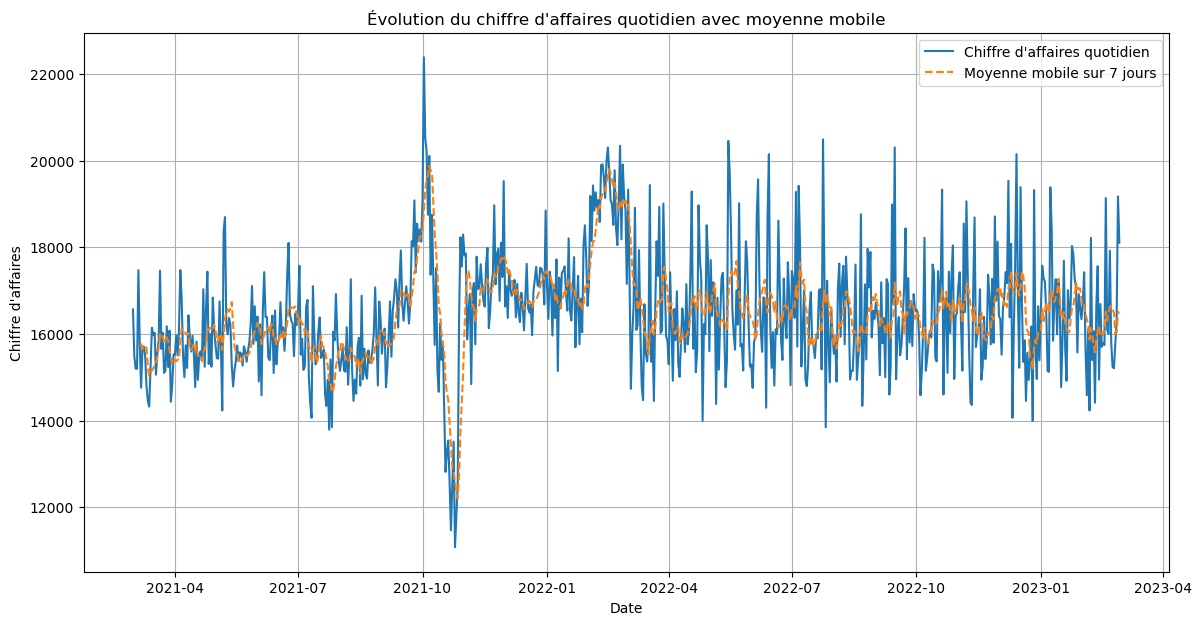

In [12]:
# Fusionner transactions avec produits pour obtenir les prix
df_transactions_products = df_transactions.merge(df_products, on='id_prod')

# Calculer le chiffre d'affaires par jour et ajouter une moyenne mobile
daily_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.date)['price'].sum()
daily_revenue = daily_revenue.to_frame(name='daily_revenue')
daily_revenue['7d_moving_avg'] = daily_revenue['daily_revenue'].rolling(window=7).mean()

# Tracer le graphique
plt.figure(figsize=(14, 7))
plt.plot(daily_revenue.index, daily_revenue['daily_revenue'], label="Chiffre d'affaires quotidien")
plt.plot(daily_revenue.index, daily_revenue['7d_moving_avg'], label='Moyenne mobile sur 7 jours', linestyle='--')
plt.title("Évolution du chiffre d'affaires quotidien avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
df_transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848


In [14]:
daily_revenue

,daily_revenue,7d_moving_avg
date,,
2021-03-01,16565.22,NaN
2021-03-02,15486.45,NaN
2021-03-03,15198.69,NaN
2021-03-04,15196.07,NaN
2021-03-05,17471.37,NaN
...,...,...
2023-02-24,15207.89,16488.778571
2023-02-25,15761.25,16006.747143
2023-02-26,16304.72,16035.021429


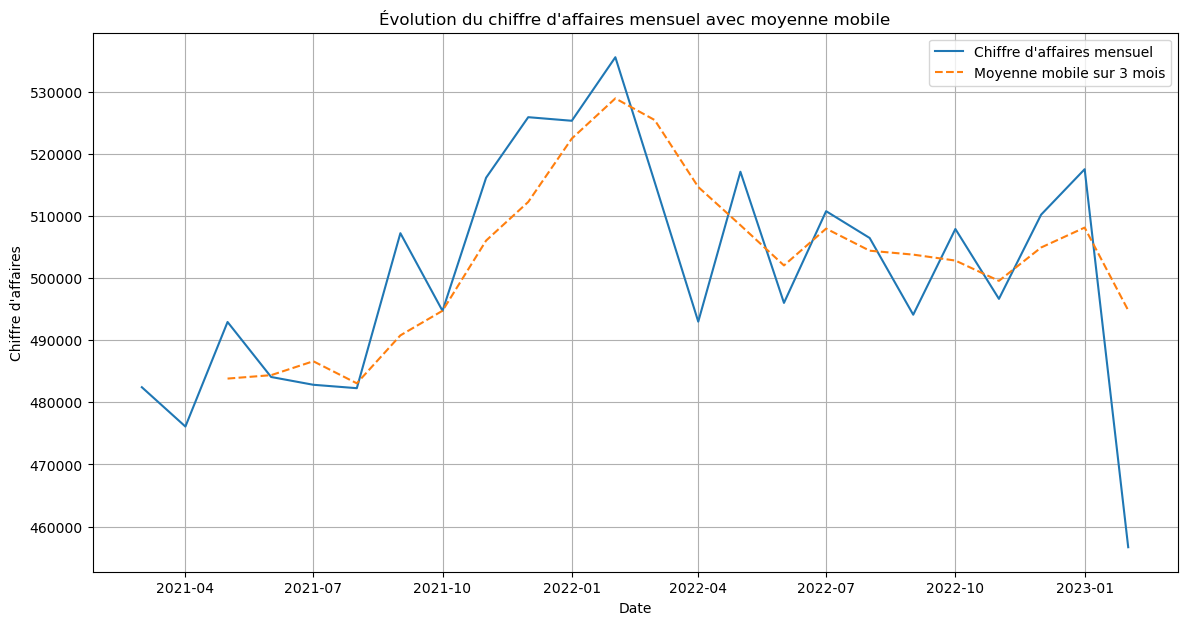

In [15]:
# Calculer le chiffre d'affaires par mois
monthly_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['price'].sum()

# Convertir l'index pour un affichage correct
monthly_revenue.index = monthly_revenue.index.to_timestamp()

# Calculer la moyenne mobile sur 3 mois (par exemple)
monthly_revenue_moving_avg = monthly_revenue.rolling(window=3).mean()

# Tracer le graphique
plt.figure(figsize=(14, 7))
plt.plot(monthly_revenue.index, monthly_revenue, label="Chiffre d'affaires mensuel")
plt.plot(monthly_revenue.index, monthly_revenue_moving_avg, label='Moyenne mobile sur 3 mois', linestyle='--')
plt.title("Évolution du chiffre d'affaires mensuel avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

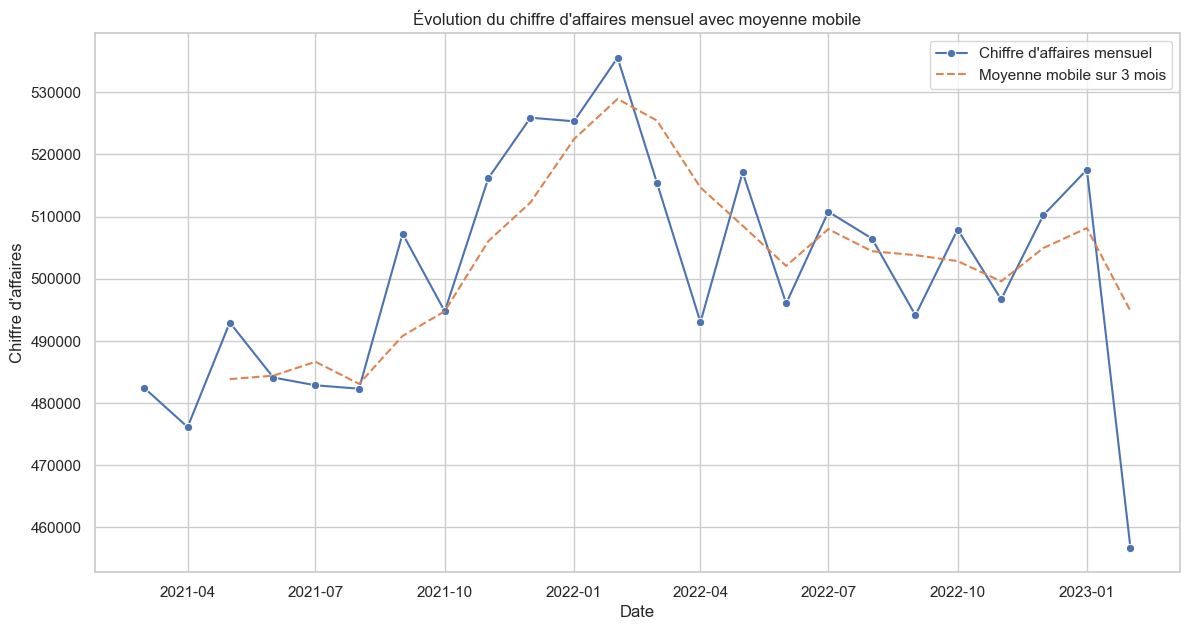

In [16]:
# Initialiser le style de Seaborn
sns.set(style="whitegrid")

# Tracer le graphique avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue, label="Chiffre d'affaires mensuel", marker='o')
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue_moving_avg, label='Moyenne mobile sur 3 mois', linestyle='--')
plt.title("Évolution du chiffre d'affaires mensuel avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2 - Chiffre d'affaires par catégorie</h3>
</div>

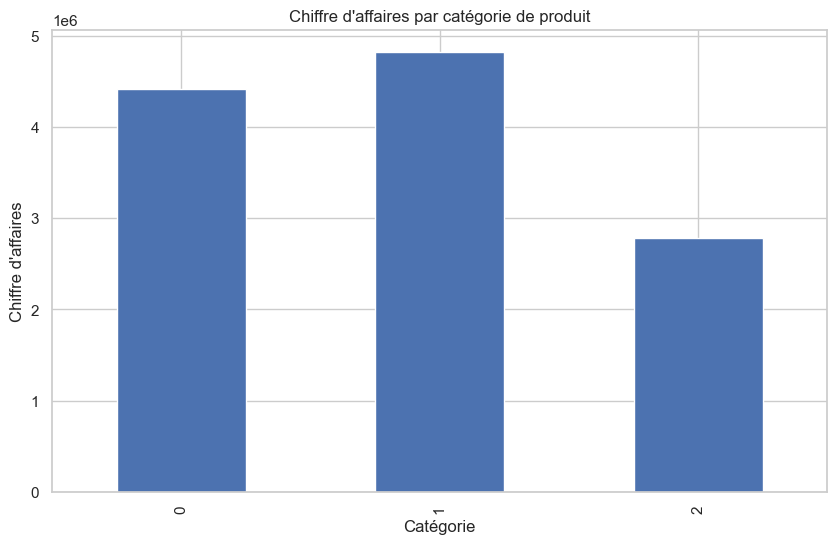

In [17]:
# Calculer le chiffre d'affaires par catégorie de produit
revenue_by_category = df_transactions_products.groupby('categ')['price'].sum()

# Tracer le graphique
plt.figure(figsize=(10, 6))
revenue_by_category.plot(kind='bar')
plt.title("Chiffre d'affaires par catégorie de produit")
plt.xlabel("Catégorie")
plt.ylabel("Chiffre d'affaires")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.3 - Nombre de clients par mois</h3>
</div>

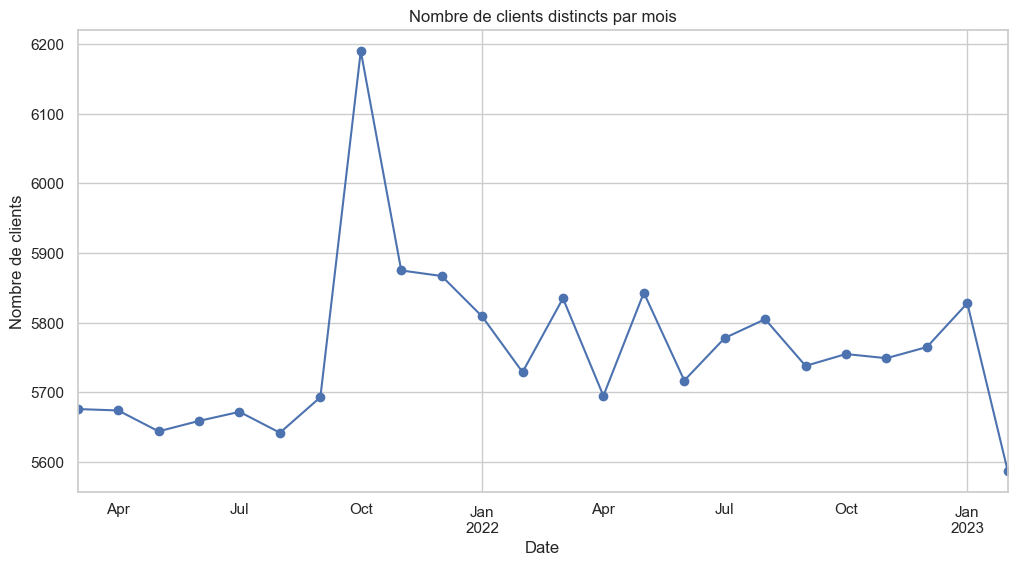

In [18]:
# Calculer le nombre de clients distincts par mois
clients_per_month = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['client_id'].nunique()

# Convertir l'index pour un affichage correct
clients_per_month.index = clients_per_month.index.to_timestamp()

# Tracer le graphique
plt.figure(figsize=(12, 6))
clients_per_month.plot(kind='line', marker='o')
plt.title("Nombre de clients distincts par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de clients")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.4 - Nombre de transactions par mois</h3>
</div>

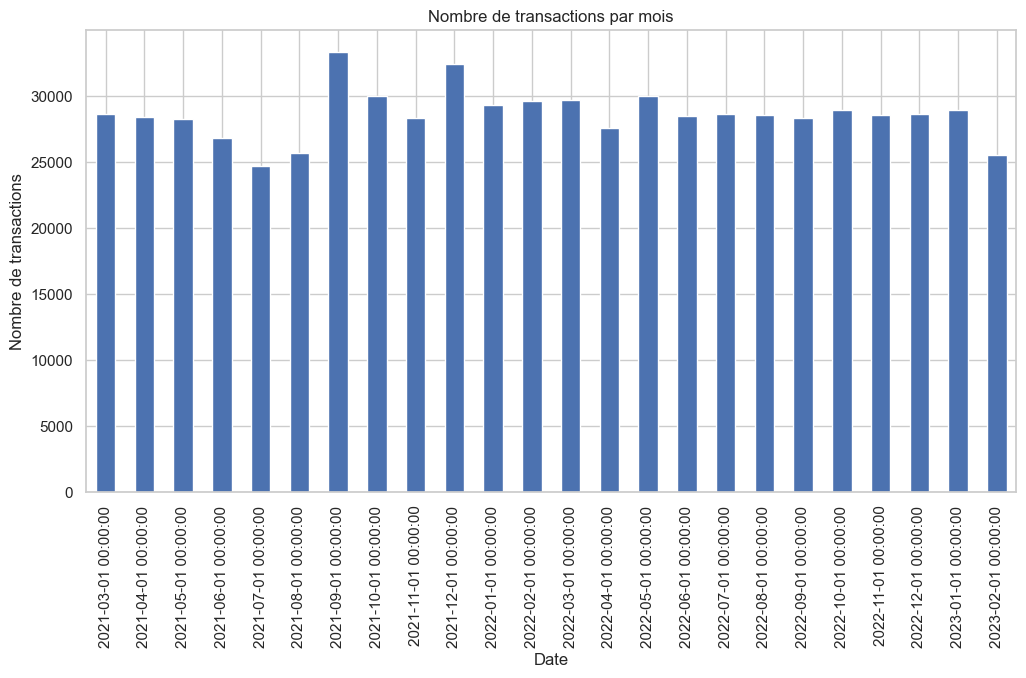

In [19]:
# Calculer le nombre de transactions par mois
transactions_per_month = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['session_id'].count()

# Convertir l'index pour un affichage correct
transactions_per_month.index = transactions_per_month.index.to_timestamp()

# Tracer le graphique
plt.figure(figsize=(12, 6))
transactions_per_month.plot(kind='bar')
plt.title("Nombre de transactions par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.5 - Nombre de produits vendus par mois</h3>
</div>

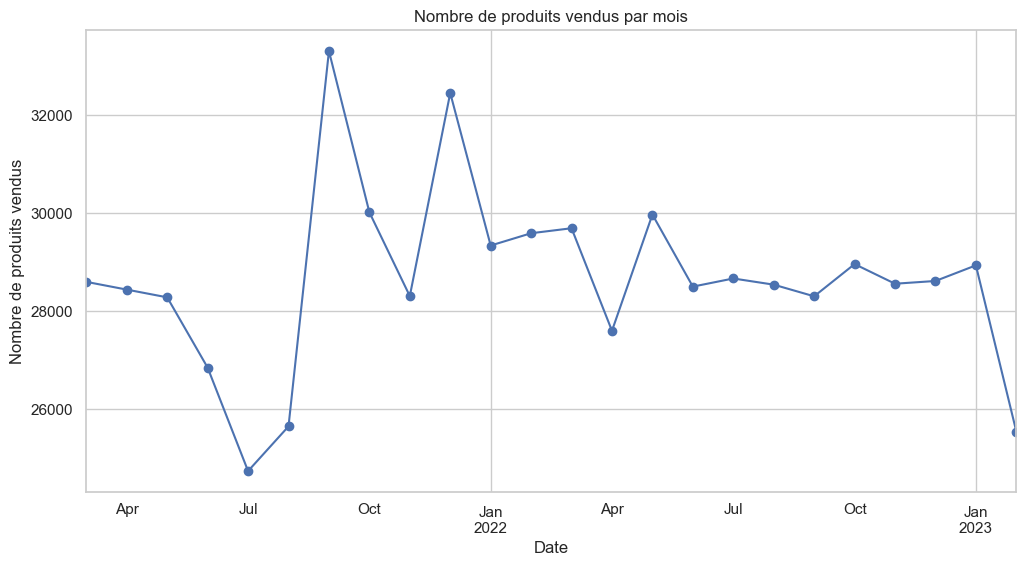

In [20]:
# Calculer le nombre de produits vendus par mois
products_sold_per_month = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['id_prod'].count()

# Convertir l'index pour un affichage correct
products_sold_per_month.index = products_sold_per_month.index.to_timestamp()

# Tracer le graphique
plt.figure(figsize=(12, 6))
products_sold_per_month.plot(kind='line', marker='o')
plt.title("Nombre de produits vendus par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de produits vendus")
plt.grid(True)
plt.show()


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">4 - Zoom sur les références</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.1 - Les Tops (produits les plus vendus)</h3>
</div>

In [21]:
# Identifier les 10 produits les plus vendus
top_products = df_transactions_products['id_prod'].value_counts().head(10)

# Afficher les résultats
print(top_products)


id_prod
1_369    2340
1_417    2269
1_414    2246
1_498    2202
1_425    2163
1_403    2040
1_413    2036
1_412    2014
1_406    2003
1_407    2001
Name: count, dtype: int64


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.2 - Les Flops (produits les moins vendus)</h3>
</div>

In [22]:
# Identifier les 10 produits les moins vendus
flop_products = df_transactions_products['id_prod'].value_counts().tail(10)

# Afficher les résultats
print(flop_products)


id_prod
0_807     1
0_1601    1
2_98      1
0_541     1
0_1151    1
2_23      1
0_886     1
0_833     1
0_2201    1
0_1633    1
Name: count, dtype: int64


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.3 - Répartition par catégorie</h3>
</div>

In [23]:
df_transactions_products

,id_prod,date,session_id,client_id,price,categ
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,11.99,0
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,19.37,0
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,4.50,0
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,6.55,0
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,16.49,0
...,...,...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,21.92,1
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,48.99,2
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,26.99,1
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,8.99,0


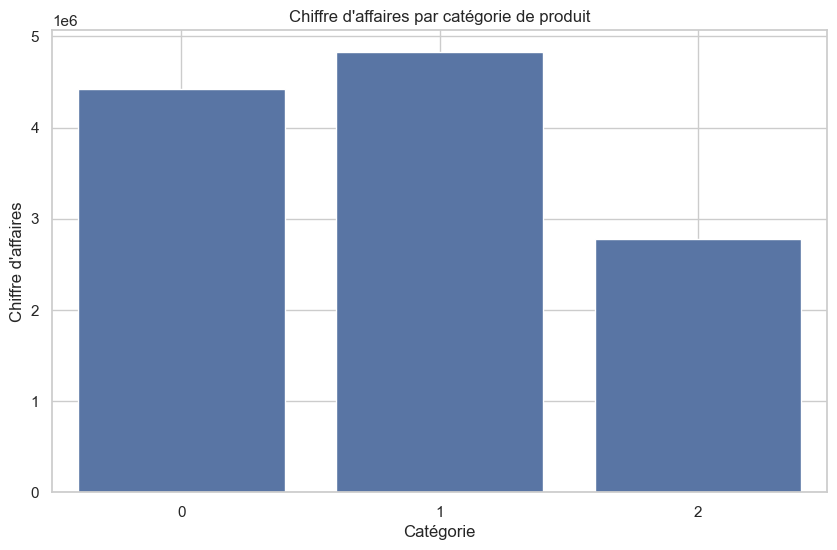

In [24]:
# Calculer le chiffre d'affaires par catégorie de produit
revenue_by_category = df_transactions_products.groupby('categ')['price'].sum()

# Tracer le graphique de répartition avec Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_by_category.index, y=revenue_by_category.values)
plt.title("Chiffre d'affaires par catégorie de produit")
plt.xlabel("Catégorie")
plt.ylabel("Chiffre d'affaires")
plt.grid(True)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.4 - Répartition du chiffre d'affaires pour les clients BtoB vs BtoC</h3>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.5 - Courbe de Lorenz</h3>
</div>

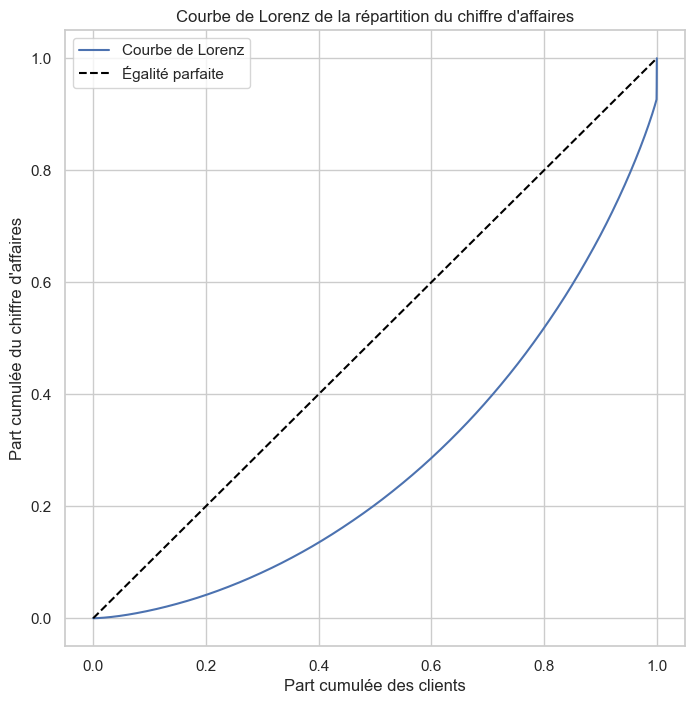

In [25]:
# Calcul du chiffre d'affaires par client
revenue_per_client = df_transactions_products.groupby('client_id')['price'].sum()

# Calculer la courbe de Lorenz
sorted_revenue = np.sort(revenue_per_client)
cumulative_revenue = np.cumsum(sorted_revenue)
lorenz_curve = cumulative_revenue / cumulative_revenue[-1]
lorenz_curve = np.insert(lorenz_curve, 0, 0)  # Ajouter un point à l'origine

# Tracer la courbe de Lorenz
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, len(lorenz_curve)), lorenz_curve, label="Courbe de Lorenz")
plt.plot([0, 1], [0, 1], '--', color='black', label="Égalité parfaite")
plt.xlabel("Part cumulée des clients")
plt.ylabel("Part cumulée du chiffre d'affaires")
plt.title("Courbe de Lorenz de la répartition du chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">5 - Analyses complémentaires</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.1 - Évolution du panier moyen par mois</h3>
</div>

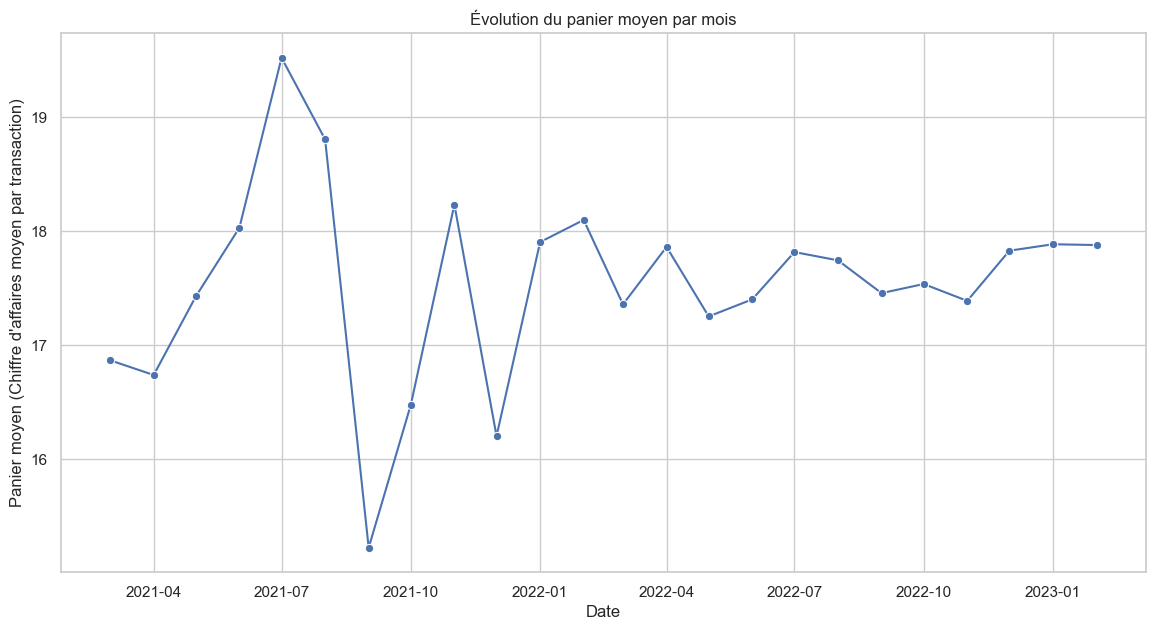

In [26]:
# Calculer le chiffre d'affaires total par mois
monthly_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['price'].sum()

# Calculer le nombre de transactions par mois
monthly_transactions = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['session_id'].count()

# Calculer le panier moyen par mois
average_basket = monthly_revenue / monthly_transactions

# Tracer le graphique
plt.figure(figsize=(14, 7))
sns.lineplot(x=average_basket.index.to_timestamp(), y=average_basket, marker='o')
plt.title("Évolution du panier moyen par mois")
plt.xlabel("Date")
plt.ylabel("Panier moyen (Chiffre d'affaires moyen par transaction)")
plt.grid(True)
plt.show()


In [27]:
monthly_revenue

date
2021-03    482440.61
2021-04    476109.30
2021-05    492943.47
2021-06    484088.56
2021-07    482835.40
2021-08    482284.79
2021-09    507240.68
2021-10    494733.16
2021-11    516167.73
2021-12    525917.28
2022-01    525338.99
2022-02    535571.50
2022-03    515456.53
2022-04    492998.94
2022-05    517132.60
2022-06    496016.12
2022-07    510783.12
2022-08    506467.27
2022-09    494114.53
2022-10    507917.77
2022-11    496664.94
2022-12    510219.50
2023-01    517540.55
2023-02    456679.76
Freq: M, Name: price, dtype: float64

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.3 - Analyse des clients fidèles</h3>
</div>

client_id
c_1609    25586
c_6714     9199
c_3454     6793
c_4958     5222
c_2140      405
c_3263      403
c_2595      398
c_2077      386
c_1637      384
c_7421      381
Name: count, dtype: int64


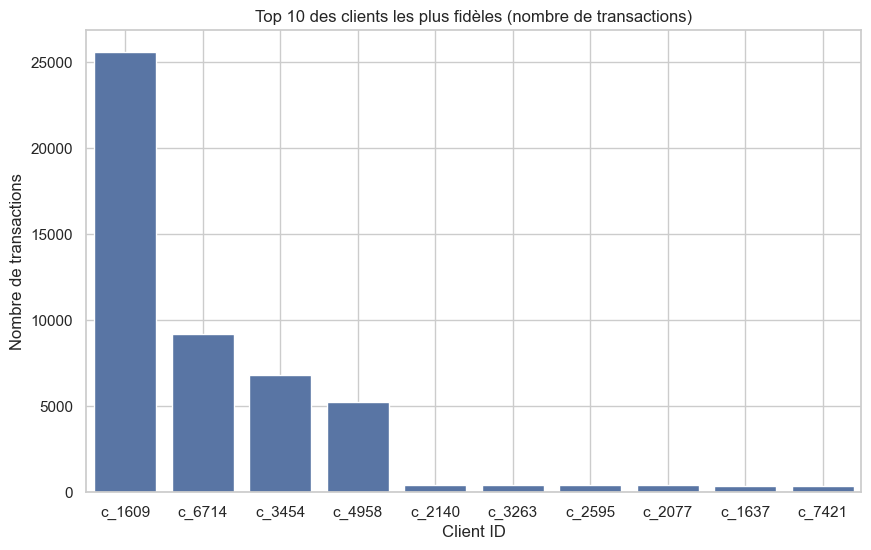

In [28]:
# Calculer le nombre de transactions par client
transactions_per_client = df_transactions_products['client_id'].value_counts()

# Identifier les 10 clients les plus fidèles
top_loyal_customers = transactions_per_client.head(10)

# Afficher les résultats
print(top_loyal_customers)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_loyal_customers.index, y=top_loyal_customers.values)
plt.title("Top 10 des clients les plus fidèles (nombre de transactions)")
plt.xlabel("Client ID")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.5 - Analyse de la durée de vie client (Customer Lifetime Value - CLV)</h3>
</div>

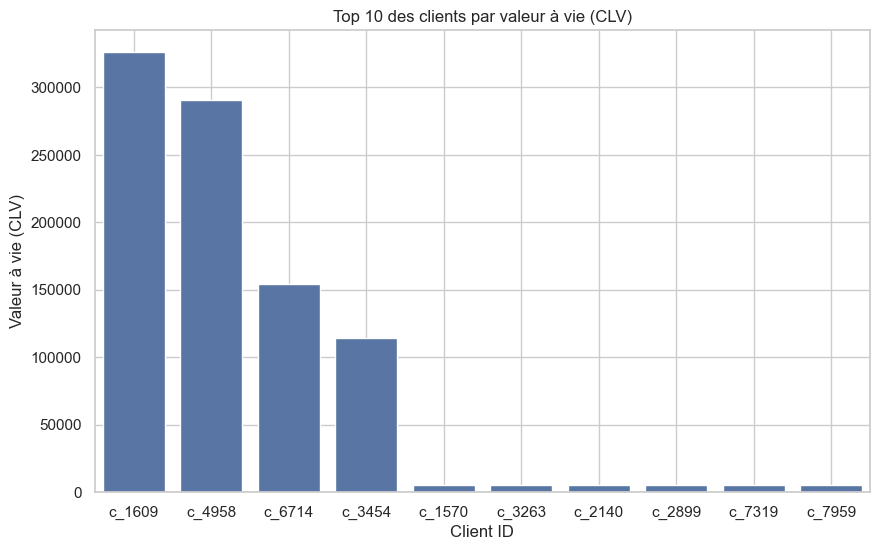

In [29]:
# Calculer la CLV par client
clv = df_transactions_products.groupby('client_id')['price'].sum()

# Afficher les clients ayant la plus haute CLV
top_clv_customers = clv.sort_values(ascending=False).head(10)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_clv_customers.index, y=top_clv_customers.values)
plt.title("Top 10 des clients par valeur à vie (CLV)")
plt.xlabel("Client ID")
plt.ylabel("Valeur à vie (CLV)")
plt.grid(True)
plt.show()


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">6 - Correlations</h2>
</div>

In [30]:
df_transactions_products.head()

,id_prod,date,session_id,client_id,price,categ
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,11.99,0
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,19.37,0
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,4.50,0
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,6.55,0
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,16.49,0


In [31]:
df_merge = df_transactions_products.merge(df_customers, on='client_id')

In [32]:
df_merge

,id_prod,date,session_id,client_id,price,categ,sex,age
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,11.99,0,f,57
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,19.37,0,m,64
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,4.50,0,m,36
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,6.55,0,f,35
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,16.49,0,f,68
...,...,...,...,...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,21.92,1,f,28
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,48.99,2,f,30
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,26.99,1,f,39
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,8.99,0,m,71


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.1 - Lien entre le genre d’un client et les catégories des livres achetés</h3>
</div>

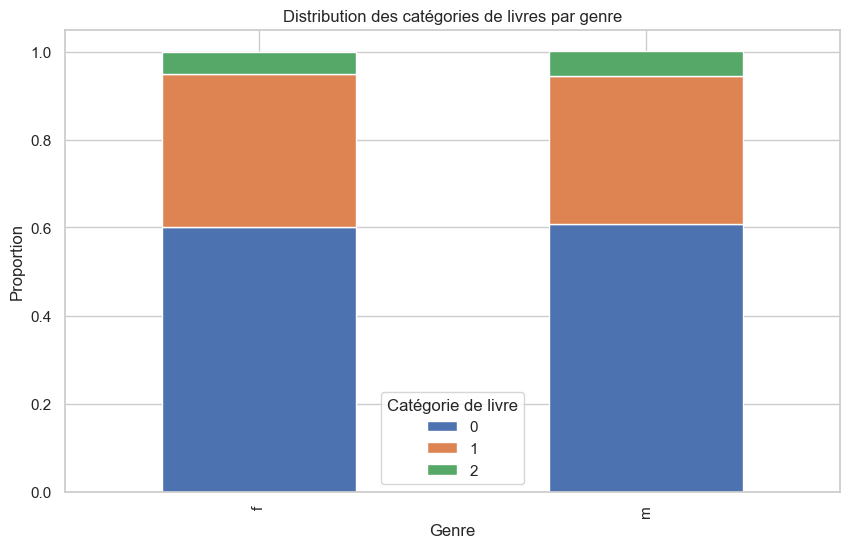

In [50]:
# Calculer la distribution des catégories de livres par genre
genre_category_distribution = pd.crosstab(df_merge['sex'], df_merge['categ'], normalize='index')

# Tracer un graphique en barres empilées
genre_category_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Distribution des catégories de livres par genre")
plt.xlabel("Genre")
plt.ylabel("Proportion")
plt.legend(title="Catégorie de livre")
plt.show()

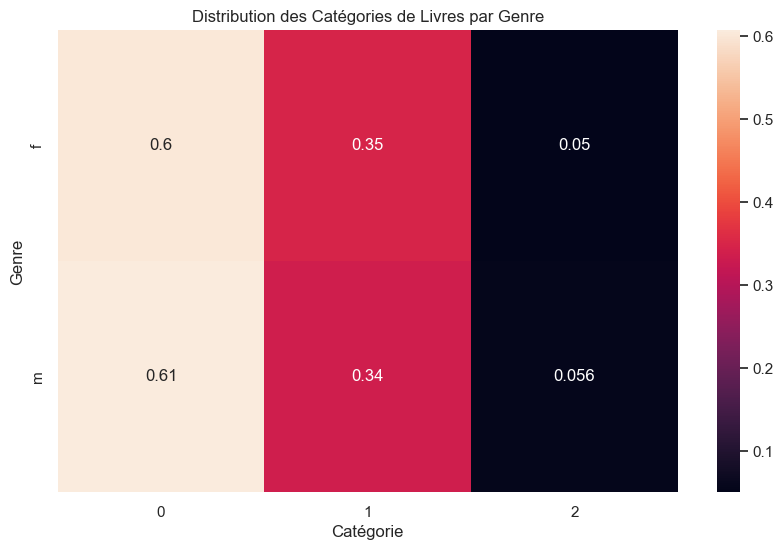

In [52]:
# Visualisation avec une heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(genre_category_distribution, annot=True)
plt.title("Distribution des Catégories de Livres par Genre")
plt.xlabel("Catégorie")
plt.ylabel("Genre")
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.2 - Lien entre l'âge des clients et le montant total des achats</h3>
</div>

In [60]:
# Regrouper les âges en tranches d'âge
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
df_merge['age_group'] = pd.cut(df_merge['age'], bins=bins, labels=labels, right=False)

# Vérifier la distribution des groupes d'âge
df_merge['age_group'].value_counts()


age_group
41-50    235083
31-40    150970
51-60    129029
20-30     65833
61-70     62529
71-80     30054
81-90     12220
Name: count, dtype: int64

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_4060\746186704.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_revenue = df_merge.groupby('age_group')['price'].sum()


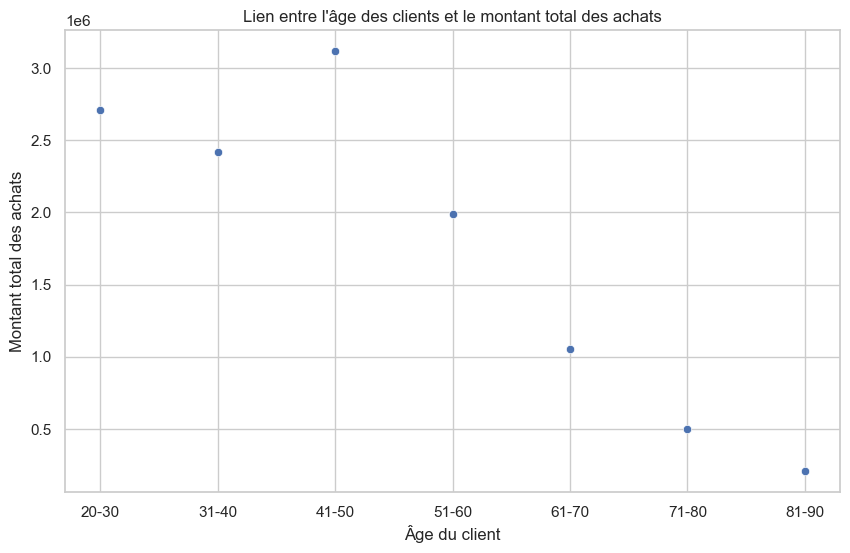

In [61]:
# Calculer le montant total des achats par client
age_revenue = df_merge.groupby('age')['price'].sum()

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.scatterplot(x=age_revenue.index, y=age_revenue.values)
plt.title("Lien entre l'âge des clients et le montant total des achats")
plt.xlabel("Âge du client")
plt.ylabel("Montant total des achats")
plt.grid(True)
plt.show()


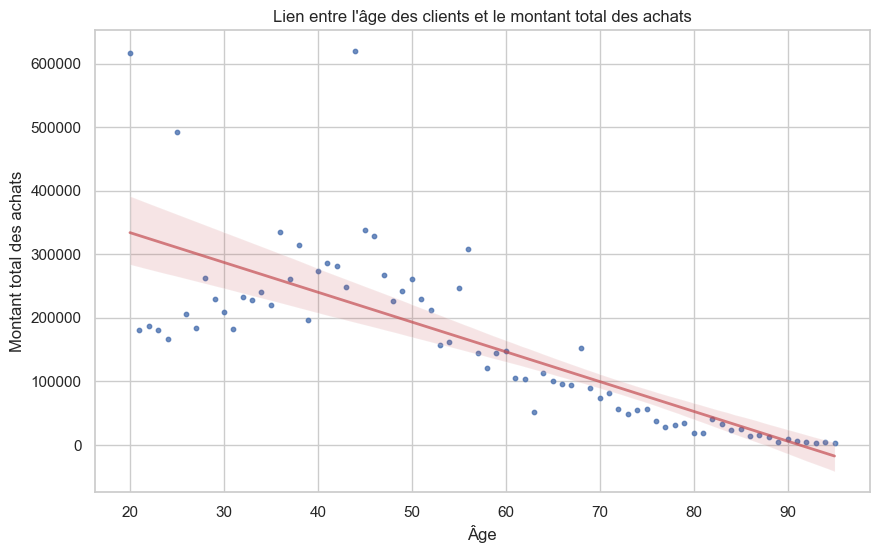

In [53]:
# Visualisation avec un scatter plot et une ligne de régression
plt.figure(figsize=(10, 6))
sns.regplot(x=age_revenue.index, y=age_revenue.values, scatter_kws={'s':10}, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title("Lien entre l'âge des clients et le montant total des achats")
plt.xlabel("Âge")
plt.ylabel("Montant total des achats")
plt.grid(True)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.3 - Lien entre l'âge des clients et la fréquence d’achat</h3>
</div>

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_4060\3786454262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_frequency = df_merge.groupby('age_group')['session_id'].nunique()


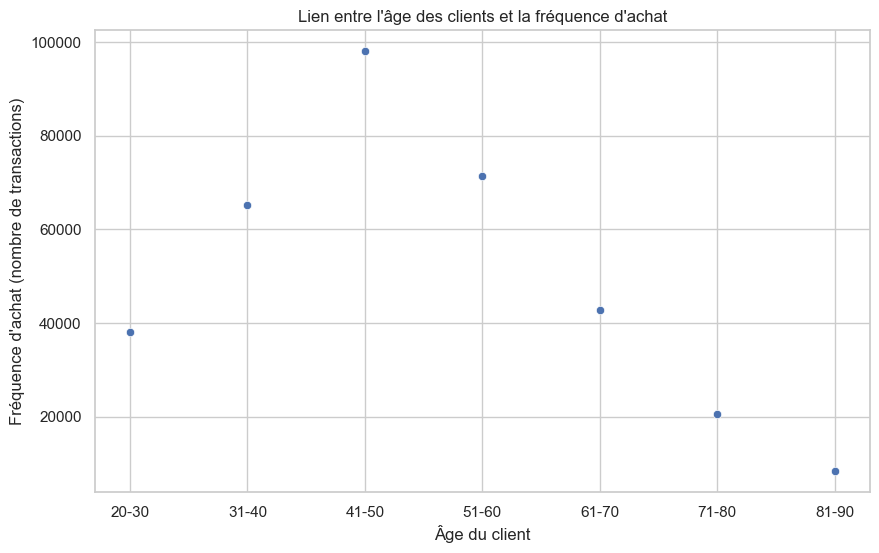

In [62]:
# Calculer la fréquence d'achat par client
age_frequency = df_merge.groupby('age_group')['session_id'].nunique()

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.scatterplot(x=age_frequency.index, y=age_frequency.values)
plt.title("Lien entre l'âge des clients et la fréquence d'achat")
plt.xlabel("Âge du client")
plt.ylabel("Fréquence d'achat (nombre de transactions)")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.4 - Lien entre l'âge des clients et la taille du panier moyen</h3>
</div>

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_4060\15538777.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_basket_size = df_merge.groupby('age_group').apply(lambda x: x['price'].sum() / x['session_id'].nunique())
C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_4060\15538777.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_basket_size = df_merge.groupby('age_group').apply(lambda x: x['price'].sum() / x['session_id'].nunique())


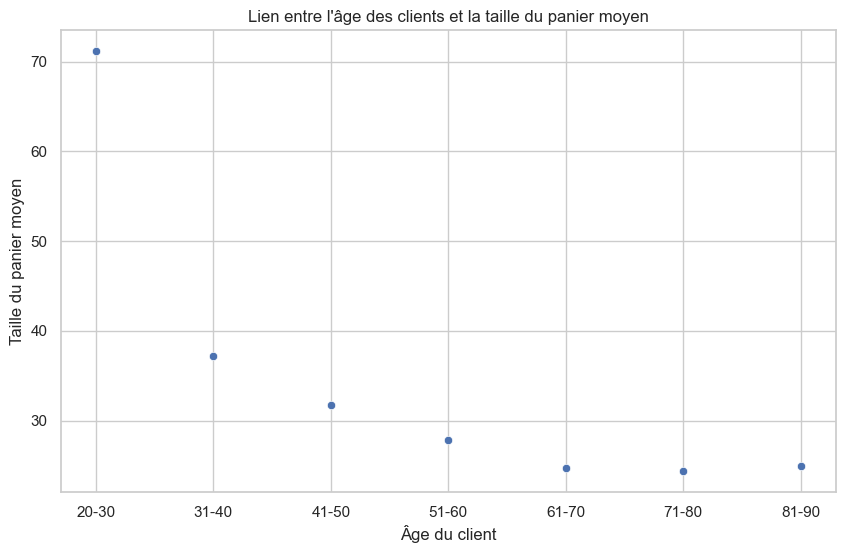

In [63]:
# Calculer le panier moyen par client
age_basket_size = df_merge.groupby('age_group').apply(lambda x: x['price'].sum() / x['session_id'].nunique())

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.scatterplot(x=age_basket_size.index, y=age_basket_size.values)
plt.title("Lien entre l'âge des clients et la taille du panier moyen")
plt.xlabel("Âge du client")
plt.ylabel("Taille du panier moyen")
plt.grid(True)
plt.show()


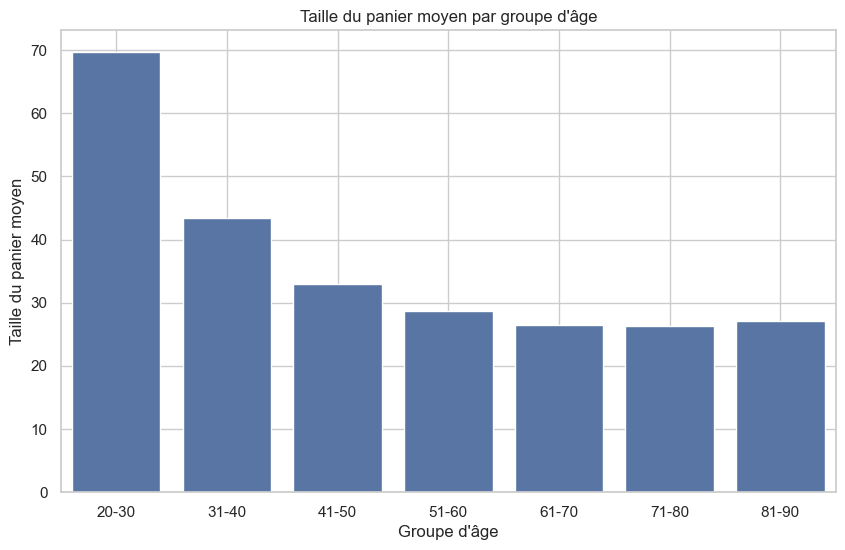

In [79]:
# Calculer la taille du panier moyen par client
age_basket_size2 = df_merge.groupby('client_id').agg({
    'age_group': 'first',  # Utilise le groupe d'âge
    'price': lambda x: x.sum() / df_merge.loc[x.index, 'session_id'].nunique()  # Calcul du panier moyen par client
})

# Visualisation avec un barplot par groupe d'âge
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='price', data=age_basket_size2, errorbar=None)
plt.title("Taille du panier moyen par groupe d'âge")
plt.xlabel("Groupe d'âge")
plt.ylabel("Taille du panier moyen")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.5 - Lien entre l'âge des clients et la catégorie des livres achetés</h3>
</div>

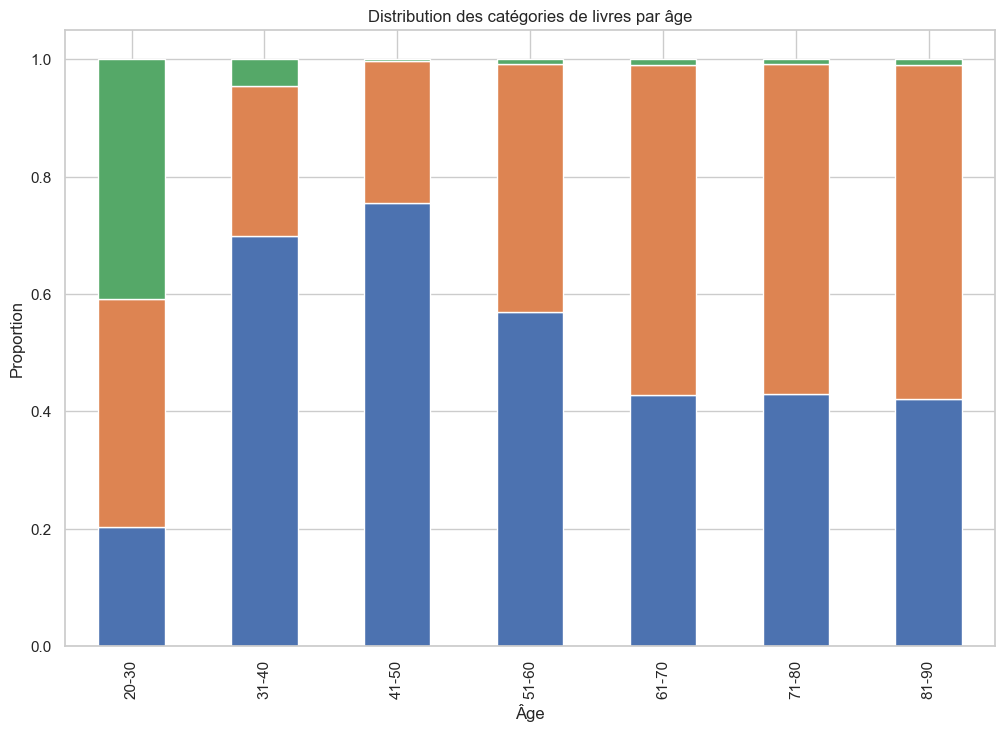

In [68]:
# Calculer la distribution des catégories de livres par âge
age_category_distribution = pd.crosstab(df_merge['age_group'], df_merge['categ'], normalize='index')

# Tracer un graphique en barres empilées
age_category_distribution.plot(kind='bar', stacked=True, figsize=(12, 8), legend=False)
plt.title("Distribution des catégories de livres par âge")
plt.xlabel("Âge")
plt.ylabel("Proportion")
plt.show()


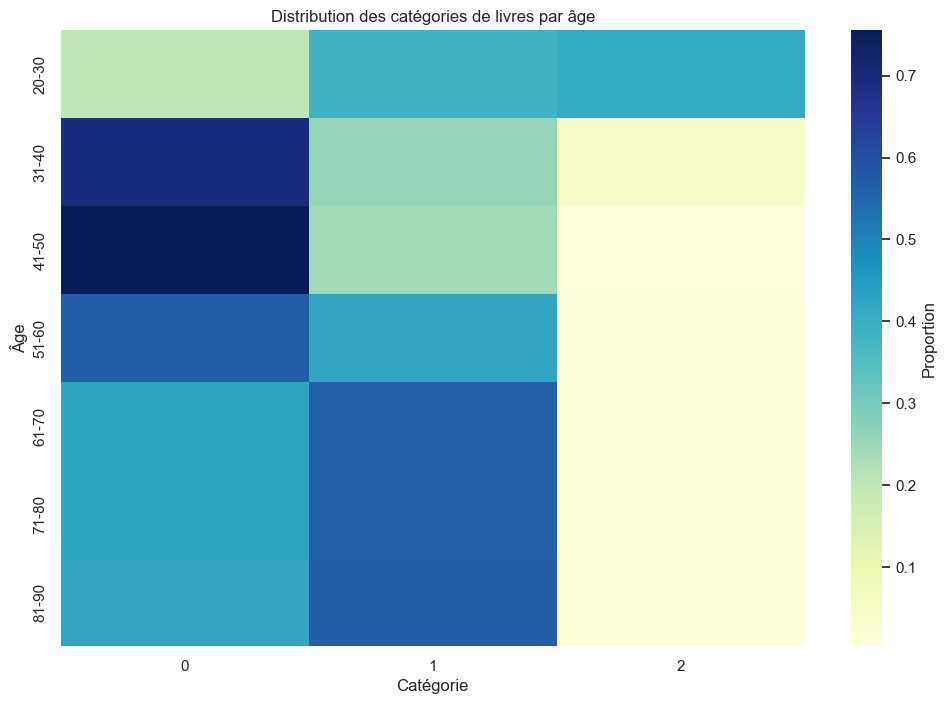

In [69]:
# Visualisation avec une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(age_category_distribution, cmap="YlGnBu", cbar_kws={'label': 'Proportion'})
plt.title("Distribution des catégories de livres par âge")
plt.xlabel("Catégorie")
plt.ylabel("Âge")
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.6 - Table de corrélation</h3>
</div>

In [38]:
df_merge

,id_prod,date,session_id,client_id,price,categ,sex,age
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,11.99,0,f,57
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,19.37,0,m,64
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,4.50,0,m,36
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,6.55,0,f,35
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,16.49,0,f,68
...,...,...,...,...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,21.92,1,f,28
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,48.99,2,f,30
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,26.99,1,f,39
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,8.99,0,m,71


In [45]:
# Calculer le montant total des achats par client
total_purchase_per_client = df_merge.groupby('client_id')['price'].sum()

# Calculer la fréquence d'achat par client (nombre de transactions)
purchase_frequency_per_client = df_merge.groupby('client_id')['session_id'].nunique()

# Calculer la taille du panier moyen par client
panier_moyen = df_merge.groupby('client_id').apply(lambda x: x['price'].sum() / x['session_id'].nunique())

# Créer un DataFrame avec toutes les variables
df_correlation = pd.DataFrame({
    'age': df_merge.groupby('client_id')['age'].first(),
    'total_purchase': total_purchase_per_client,
    'purchase_frequency': purchase_frequency_per_client,
    'panier_moyen': panier_moyen,
})

# Afficher les premières lignes pour vérification
df_correlation.head()


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_4060\3378224475.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panier_moyen = df_merge.groupby('client_id').apply(lambda x: x['price'].sum() / x['session_id'].nunique())


,age,total_purchase,purchase_frequency,panier_moyen
client_id,,,,
c_1,69,629.02,34,18.500588
c_10,68,1353.60,34,39.811765
c_100,32,254.85,5,50.970000
c_1000,58,2291.88,94,24.381702
c_1001,42,1823.85,47,38.805319


In [46]:
# Calculer la matrice de corrélation
correlation_matrix = df_correlation.corr()

# Afficher la matrice de corrélation
print(correlation_matrix)


                         age  total_purchase  purchase_frequency  panier_moyen
age                 1.000000       -0.039756            0.034139     -0.616540
total_purchase     -0.039756        1.000000            0.909231      0.036377
purchase_frequency  0.034139        0.909231            1.000000     -0.068223
panier_moyen       -0.616540        0.036377           -0.068223      1.000000


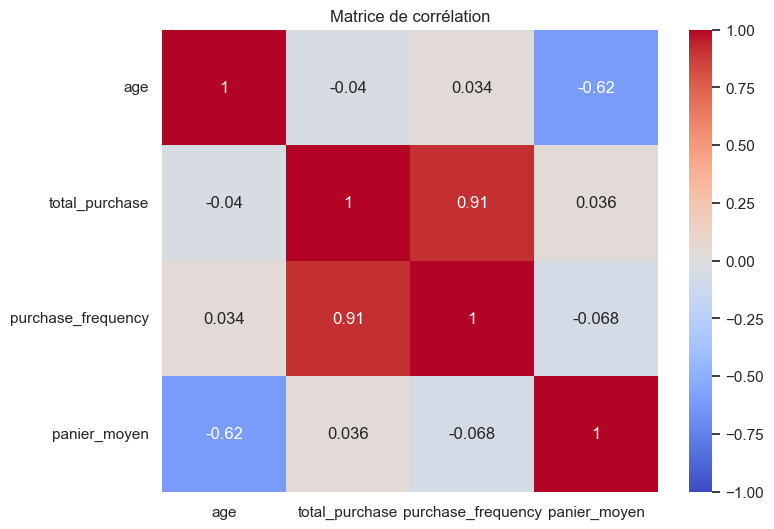

In [47]:
# Tracer la heatmap de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de corrélation")
plt.show()
